In [75]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, QuantumRegister, ClassicalRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization.utils import _get_layered_instructions
from ibm_quantum_widgets import *

from qiskit.circuit.library import QFT

from numpy import pi

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-05-13 10:45:31,228: Credentials are already in use. The existing account in the session will be replaced.


In [76]:
"""Creates a list of sub-circuits of a QuantumCircuit by column"""

'Creates a list of sub-circuits of a QuantumCircuit by column'

In [77]:
# Setup simulators
state_vector_sim = Aer.get_backend('statevector_simulator')
unitary_sim = Aer.get_backend('unitary_simulator')

# Define helper functions
def get_state_vector(circuit):
    return state_vector_sim.run(circuit).result().get_statevector()

def get_unitary_matrix(circuit):
    return execute(circuit, unitary_sim).result().get_unitary()

# Pretty-printing
def print_matrix(matrix):
    for row in matrix:
        for num in row:
            print(f"{np.around(num, 2)}   ", end='')
        print('')
    print('\n---')
    
def print_state_vector(svec):
    for num in svec:
        print(np.around(num, 2))
    print('---')

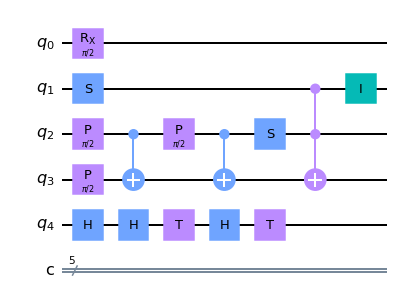

In [78]:
# Place circuit here

#From QASM string
qasm = """
OPENQASM 2.0;
include "qelib1.inc";

qreg q[5];
creg c[5];

s q[1];
p(pi/2) q[2];
p(pi/2) q[3];
h q[4];
cx q[2],q[3];
h q[4];
p(pi/2) q[2];
t q[4];
cx q[2],q[3];
h q[4];
s q[2];
t q[4];
ccx q[1],q[2],q[3];
id q[1];
rx(pi/2) q[0];
"""
circuit = QuantumCircuit.from_qasm_str(qasm)
circuit.draw()

In [91]:
# Each sub-circuit will have the same number of qubits as the original circuit
num_qubits = circuit.num_qubits
# We only care about the number of columns from _get_layered_instructions()
_, _, ops = _get_layered_instructions(circuit)
num_columns = len(ops)
print(f'Number of columns: {num_columns}')
print(f'Number of qubits: {num_qubits}')

Number of columns: 7
Number of qubits: 5


In [92]:
print(f'A preview of circuit.data ({len(circuit.data)} gates total)')
for i in range(0, 5):
    print(circuit.data[i])

A preview of circuit.data (15 gates total)
(<qiskit.circuit.library.standard_gates.rx.RXGate object at 0x7fa0dfb16c40>, [Qubit(QuantumRegister(5, 'q'), 0)], [])
(<qiskit.circuit.library.standard_gates.s.SGate object at 0x7fa0dfb16f70>, [Qubit(QuantumRegister(5, 'q'), 1)], [])
(<qiskit.circuit.library.standard_gates.p.PhaseGate object at 0x7fa0dfb16f40>, [Qubit(QuantumRegister(5, 'q'), 2)], [])
(<qiskit.circuit.library.standard_gates.p.PhaseGate object at 0x7fa0dfb16f10>, [Qubit(QuantumRegister(5, 'q'), 3)], [])
(<qiskit.circuit.library.standard_gates.x.CXGate object at 0x7fa0dfb16ee0>, [Qubit(QuantumRegister(5, 'q'), 2), Qubit(QuantumRegister(5, 'q'), 3)], [])


In [105]:
# Initialize the data structures that hold column information

# A list that keeps track of the column to insert the next gate
# curr_column[qubit.index] = column
curr_column = [0] * num_qubits # creates a list of size num_qubits
print('curr_columns', curr_column)

# A 2-D array that holds the actual instructions by column
# where columns[0] = [(insn, qargs, cargs) tuples] (list of instructions at column 0)
columns = []
for i in range(num_columns):
    columns.append([])
print('columns', columns)

curr_columns [0, 0, 0, 0, 0]
columns [[], [], [], [], [], [], []]


In [102]:
# Obtain the instructions by column
for (insn, qargs, cargs) in circuit.data:    
    # First find the right-most column
    # This will determine the column of all the gates
    col = -1
    anchor_qubit = -1 # the qubit with the highest column value
    for qubit in qargs:
        if curr_column[qubit.index] > col:
            col = curr_column[qubit.index]
            anchor_qubit = qubit.index
    if col == -1 or anchor_qubit == -1:
        print('Something went wrong...')
        continue
    
    # At this point "col" contains the rightmost column
    columns[col].append((insn, qargs, cargs))
    # Update the column for this qubit for the next gate in the future
    curr_column[anchor_qubit] += 1
    # All the qubits in this instruction will have the same column value
    # for the next gate in the future
    for qubit in qargs:
        curr_column[qubit.index] = curr_column[anchor_qubit]

print(f'By column ({num_columns} columns total)')
for col in range(0, num_columns):
    print(f'Column {col}: {len(columns[col])} gates')
    for (insn, qargs, cargs) in columns[col]:
        print(insn)
        print(qargs)
    print('---')

curr_columns [0, 0, 0, 0, 0]
columns [[], [], [], [], [], [], []]
---
By column (7 columns total)
Column 0: 5 gates
[Qubit(QuantumRegister(5, 'q'), 0)]
[Qubit(QuantumRegister(5, 'q'), 1)]
[Qubit(QuantumRegister(5, 'q'), 2)]
[Qubit(QuantumRegister(5, 'q'), 3)]
[Qubit(QuantumRegister(5, 'q'), 4)]
---
Column 1: 2 gates
[Qubit(QuantumRegister(5, 'q'), 2), Qubit(QuantumRegister(5, 'q'), 3)]
[Qubit(QuantumRegister(5, 'q'), 4)]
---
Column 2: 2 gates
[Qubit(QuantumRegister(5, 'q'), 2)]
[Qubit(QuantumRegister(5, 'q'), 4)]
---
Column 3: 2 gates
[Qubit(QuantumRegister(5, 'q'), 2), Qubit(QuantumRegister(5, 'q'), 3)]
[Qubit(QuantumRegister(5, 'q'), 4)]
---
Column 4: 2 gates
[Qubit(QuantumRegister(5, 'q'), 2)]
[Qubit(QuantumRegister(5, 'q'), 4)]
---
Column 5: 1 gates
[Qubit(QuantumRegister(5, 'q'), 1), Qubit(QuantumRegister(5, 'q'), 2), Qubit(QuantumRegister(5, 'q'), 3)]
---
Column 6: 1 gates
[Qubit(QuantumRegister(5, 'q'), 1)]
---


<ipython-input-102-03eda23b6e5d>:25: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  if curr_column[qubit.index] > col:
<ipython-input-102-03eda23b6e5d>:26: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  col = curr_column[qubit.index]
<ipython-input-102-03eda23b6e5d>:27: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  anchor_qubit = qubit.index
<ipython-input-102-03eda23b6e5d>:41: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  curr_column[qubit.index] = curr_column[anchor_qubit]


In [ ]:
# Build the subcircuits by column
sub_circuits = []
for col in range(0, num_columns):
    sub_circuit = QuantumCircuit(num_qubits)
    for (insn, qargs, cargs) in columns[col]:
        sub_circuit.append(insn, qargs, cargs)
    sub_circuits.append(sub_circuit)

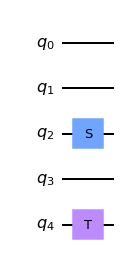

In [34]:
sub_circuits[4].draw()

In [19]:
# Each sub-circuit will have the same number of qubits as the original circuit
num_qubits = circuit.num_qubits
sub_circuits = []
amplitudes = []
phases = []

# https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.html#qiskit.circuit.QuantumCircuit.data
prev_qubit = 0
for (insn, qargs, cargs) in circuit.data:
    print(insn)
    print(qargs)
    #print(cargs)
    print('---')
    sub_circuit = QuantumCircuit(num_qubits)
    
    state_vector = get_state_vector(sub_circuit)
    #print_state_vector(state_vector)
    amplitudes.append(abs(state_vector))
    phases.append(np.angle(state_vector))
    
    #unitary_matrix = get_unitary_matrix(circuit)
    #print_matrix(unitary_matrix)
    
    # https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.html#qiskit.circuit.QuantumCircuit.append
    sub_circuit.append(insn, qargs, cargs)
    sub_circuits.append(sub_circuit)

print('%i sub circuits' % len(sub_circuits))

[Qubit(QuantumRegister(5, 'q'), 0)]
---
[Qubit(QuantumRegister(5, 'q'), 1)]
---
[Qubit(QuantumRegister(5, 'q'), 2)]
---
[Qubit(QuantumRegister(5, 'q'), 3)]
---
[Qubit(QuantumRegister(5, 'q'), 2), Qubit(QuantumRegister(5, 'q'), 3)]
---
[Qubit(QuantumRegister(5, 'q'), 2)]
---
[Qubit(QuantumRegister(5, 'q'), 2), Qubit(QuantumRegister(5, 'q'), 3)]
---
[Qubit(QuantumRegister(5, 'q'), 2)]
---
[Qubit(QuantumRegister(5, 'q'), 1), Qubit(QuantumRegister(5, 'q'), 2), Qubit(QuantumRegister(5, 'q'), 3)]
---
[Qubit(QuantumRegister(5, 'q'), 1)]
---
[Qubit(QuantumRegister(5, 'q'), 4)]
---
[Qubit(QuantumRegister(5, 'q'), 4)]
---
[Qubit(QuantumRegister(5, 'q'), 4)]
---
[Qubit(QuantumRegister(5, 'q'), 4)]
---
[Qubit(QuantumRegister(5, 'q'), 4)]
---
15 sub circuits


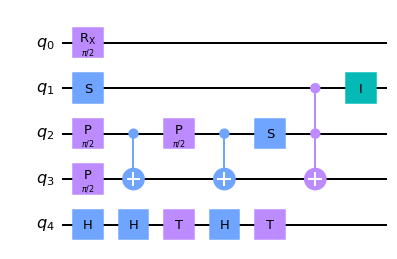

In [35]:
# Check if the combined circuit looks like the original
combined_circuit = sub_circuits[0]
for i in range(1, len(sub_circuits)):
    # https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.html#qiskit.circuit.QuantumCircuit.compose
    combined_circuit = combined_circuit.compose(sub_circuits[i])
    # combined_circuit += sub_circuits[i]

# Print combined circuit
combined_circuit.draw()

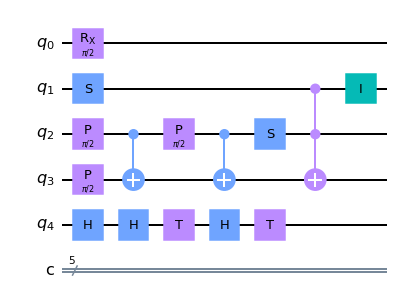

In [36]:
# Print original
circuit.draw()

In [37]:
# Correct way to compare two circuits
# https://quantumcomputing.stackexchange.com/questions/13723/test-equivalence-of-circuits-exactly-on-qiskit
from qiskit.quantum_info import Statevector
print('Statevector compare: ', Statevector.from_instruction(circuit).equiv(Statevector.from_instruction(combined_circuit))) # True
print('Raw compare: ', circuit == combined_circuit)

Statevector compare:  True
Raw compare:  False
